Code repurposed from Kaggle [https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-cryptocurrencies]

## import dependencies

In [1]:
import pandas as pd
import pandas_datareader as web
import numpy as np
from pathlib import Path
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

from yahoo_fin.stock_info import get_data

%matplotlib inline

## load and inspect data

In [2]:
crypto_currency = 'ETH'
against_currency = 'USD'

start = dt.datetime(2014,1,1)
end = dt.datetime.now()

base_df = get_data(f'{crypto_currency}-{against_currency}', start, end, index_as_date = True, interval = '1d')
base_df

,open,high,low,close,adjclose,volume,ticker
2015-08-06,2.831620,3.536610,2.521120,2.772120,2.772120,1.643290e+05,ETH-USD
2015-08-07,2.793760,2.798810,0.714725,0.753325,0.753325,6.741880e+05,ETH-USD
2015-08-08,0.706136,0.879810,0.629191,0.701897,0.701897,5.321700e+05,ETH-USD
2015-08-09,0.713989,0.729854,0.636546,0.708448,0.708448,4.052830e+05,ETH-USD
2015-08-10,0.708087,1.131410,0.663235,1.067860,1.067860,1.463100e+06,ETH-USD
...,...,...,...,...,...,...,...
2021-07-02,2150.834961,2237.567139,2117.590088,2226.114258,2226.114258,1.743336e+10,ETH-USD
2021-07-03,2226.550293,2384.286865,2190.837646,2321.724121,2321.724121,1.878711e+10,ETH-USD
2021-07-04,2321.922852,2321.922852,2163.041504,2198.582520,2198.582520,2.010379e+10,ETH-USD
2021-07-05,2197.919434,2346.294922,2197.919434,2324.679443,2324.679443,2.089186e+10,ETH-USD


In [3]:
base_df['spread'] = base_df.high - base_df.low
base_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2162 entries, 2015-08-06 to 2021-07-06
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      2158 non-null   float64
 1   high      2158 non-null   float64
 2   low       2158 non-null   float64
 3   close     2158 non-null   float64
 4   adjclose  2158 non-null   float64
 5   volume    2158 non-null   float64
 6   ticker    2162 non-null   object 
 7   spread    2158 non-null   float64
dtypes: float64(7), object(1)
memory usage: 152.0+ KB


## Plot the closing value of Ethereum over time

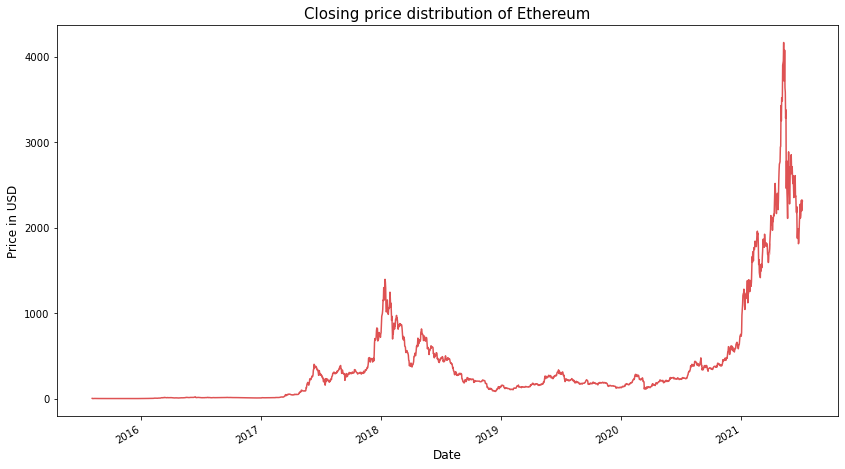

In [4]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(14,8))

sns.lineplot(y = base_df.close.values, x=base_df.index.values, alpha=0.8, color=color[3])
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

fig.autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price in USD', fontsize=12)
plt.title("Closing price distribution of Ethereum", fontsize=15)
plt.show()

Text(0.5, 1.0, 'Daily price spread of Ethereum')

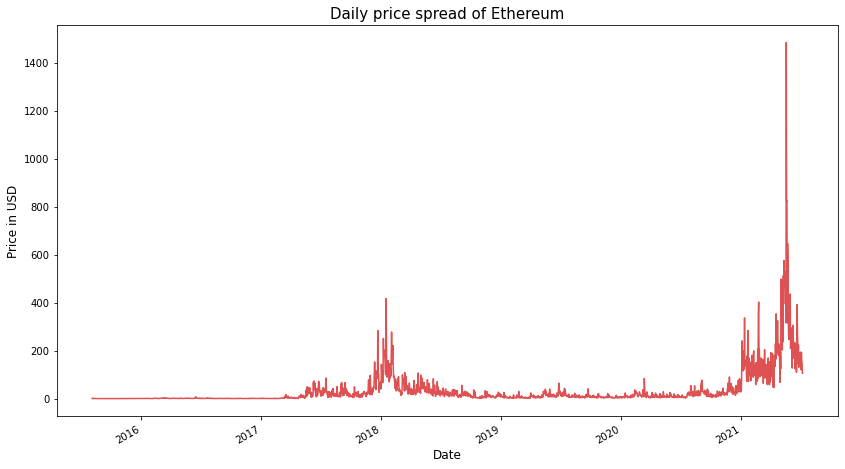

In [5]:
fig, ax = plt.subplots(figsize=(14,8))

sns.lineplot(y = base_df.spread.values, x=base_df.index.values, alpha=0.8, color=color[3])
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

fig.autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price in USD', fontsize=12)
plt.title("Daily price spread of Ethereum", fontsize=15)

## Candlestick chart

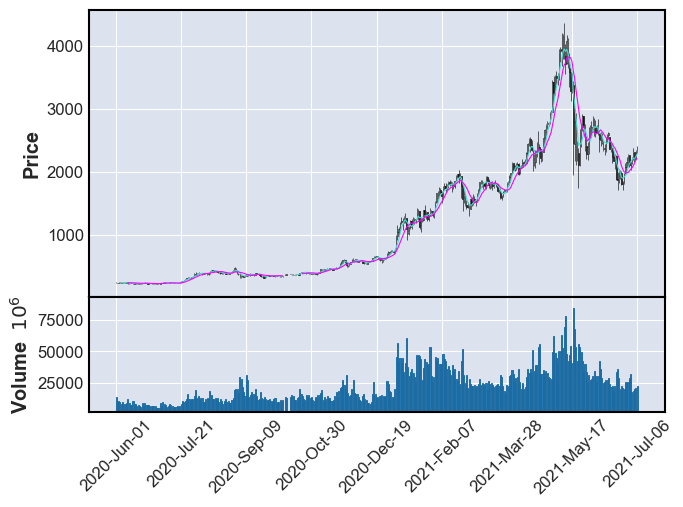

In [6]:
import matplotlib.ticker as mticker
import mplfinance as mpf

temp_base_df = base_df.copy(deep=False)

temp_base_df = temp_base_df.drop(['spread'], axis=1)
mpf.plot(temp_base_df.loc['2020-6-1':], type='candle', mav=(5,10), volume=True)

## Future Price Prediction

In [7]:
from fbprophet import Prophet

In [8]:
price_predict_df = base_df['close'].copy(deep=False).reset_index()
price_predict_df.columns = ["ds", "y"]
#price_predict_df = price_predict_df[price_predict_df['ds']>'2020-6-1']
price_predict_df

,ds,y
0,2015-08-06,2.772120
1,2015-08-07,0.753325
2,2015-08-08,0.701897
3,2015-08-09,0.708448
4,2015-08-10,1.067860
...,...,...
2157,2021-07-02,2226.114258
2158,2021-07-03,2321.724121
2159,2021-07-04,2198.582520
2160,2021-07-05,2324.679443


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
2181,2021-08-01,2630.957410,2459.114647,2794.682305
2182,2021-08-02,2632.234483,2456.380231,2806.680180
2183,2021-08-03,2629.054163,2453.065611,2804.867977
2184,2021-08-04,2630.237630,2463.183622,2809.012028
2185,2021-08-05,2624.422970,2439.399437,2810.299142


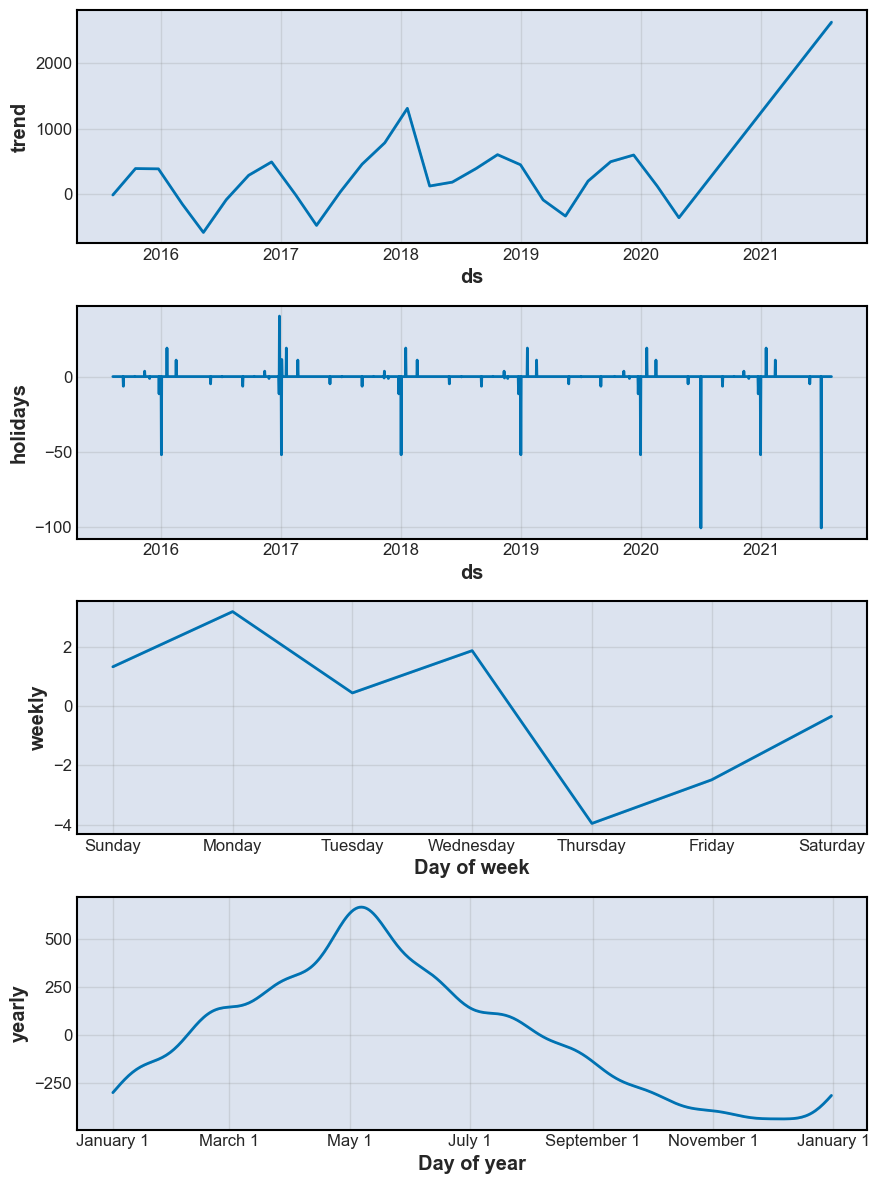

In [9]:
m = Prophet(changepoint_prior_scale=.7)
m.add_country_holidays(country_name='US')
#m.add_country_holidays(country_name='CN')
m.fit(price_predict_df);
m.train_holiday_names

future = m.make_future_dataframe(periods=30)

forecast = m.predict(future)
fig = m.plot_components(forecast)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

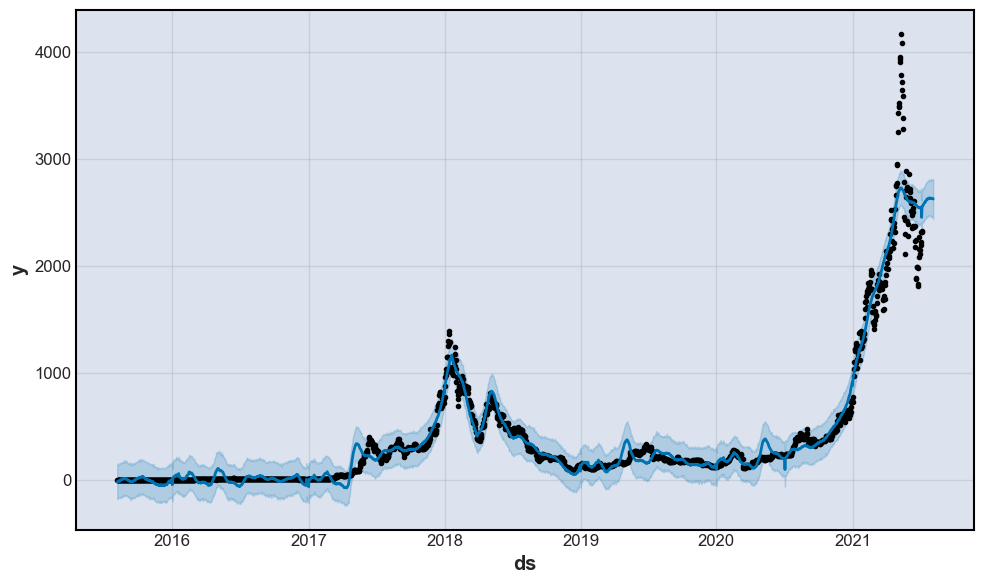

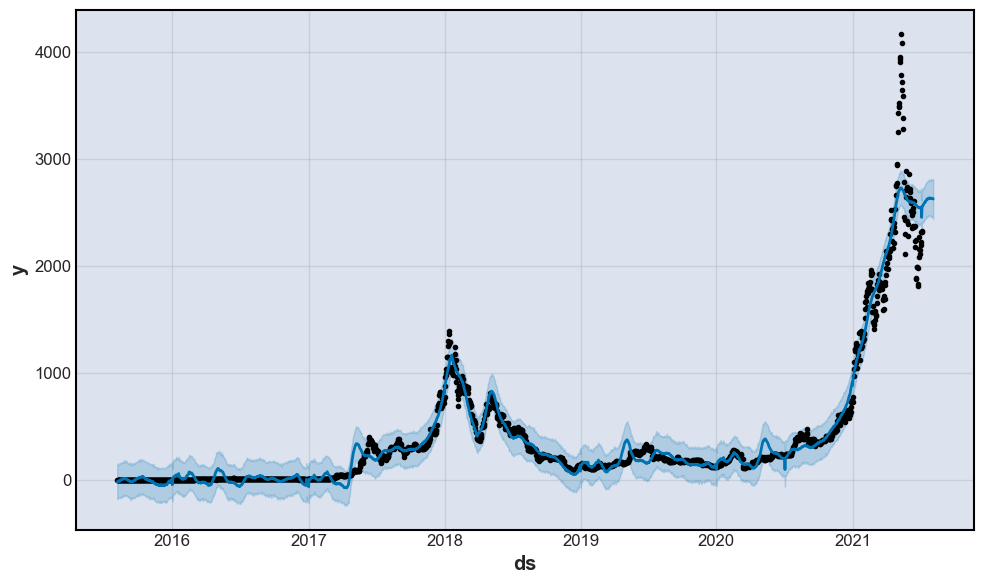

In [10]:
m.plot(forecast)